In [70]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions
from torchvision.utils import make_grid, save_image
import imageio
plt.style.use('ggplot')

def save_generator_image(image, path):
    save_image(image, path)

In [71]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma)
        return torch.distributions.Normal(loc=mu, scale=sigma)


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = torch.tanh(self.linear2(x))
        return torch.distributions.Normal(mu, torch.ones_like(mu))

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        q_z = self.encoder(state)
        z = q_z.rsample()
        return self.decoder(z), q_z

transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize the images to be -0.5, 0.5
     transforms.Normalize(0.5, 1)]
    )

class IWAE(VAE):
    def __init__(self, encoder, decoder, k=1):
        super(IWAE, self).__init__(encoder, decoder)
        self.k = k

    def forward(self, state):
        q_z = self.encoder(state)

        # Draw k samples
        z_samples = [q_z.rsample() for _ in range(self.k)]
        reconstructions = [self.decoder(z) for z in z_samples]

        return reconstructions, q_z, z_samples

to_pil_image = transforms.ToPILImage()

In [72]:
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

input_dim = 28 * 28
batch_size = 300
num_epochs = 2
learning_rate = 0.001
hidden_size = 512
latent_size = 16
latent_size_list = [2,8,32,128]
# IWAE
k = 5

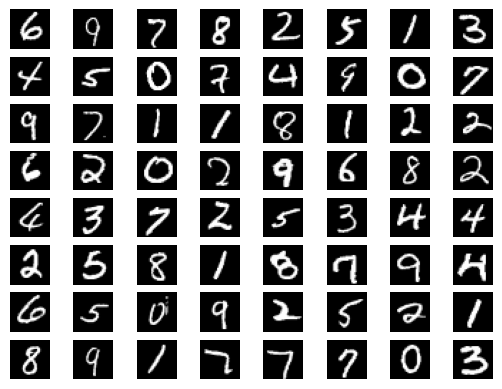

In [73]:
dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=64,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

sample,_= next(iter(dataloader))

plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i][0], cmap="gray")
    plt.axis('off')

plt.savefig('sample')


In [74]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

print('Number of samples: ', len(mnist))



Number of samples:  60000


In [75]:
losses = [[],[],[],[]] # to store KL loss after each epoch
losses_r = [[],[],[],[]] # to store reconstruction loss after each epoch
images = [[],[],[],[]] # to store images generatd by the generator

In [76]:
sample = sample.view(-1,input_dim).to(device)

In [77]:
for index,latent_size in enumerate(latent_size_list):
    encoder = Encoder(input_dim, hidden_size, latent_size)
    decoder = Decoder(latent_size, hidden_size, input_dim)
    iwae = IWAE(encoder, decoder, 5).to(device)
    optimizer = optim.Adam(iwae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        i=0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            p_x, q_z, z_samples = iwae(inputs)
            kls = torch.distributions.kl_divergence(
                q_z,
                torch.distributions.Normal(0, 1.)
            ).sum(-1)
            log_weights_lst = []
            # Compute log weights
            for j in range(k):
                log_likelihoods = p_x[j].log_prob(inputs).sum(-1)
                log_weights = log_likelihoods - kls
                log_weights_lst.append(log_weights)
            # Use the log-sum-exp trick
            log_sum = torch.logsumexp(torch.stack(log_weights_lst), dim=0) - torch.log(torch.tensor(float(k)))
            loss = - log_sum.mean(0)
            loss.backward()
            optimizer.step()
            l = loss.item()
            losses[index].append(l)
            if(i%10 == 0):
                sample_d,_= iwae(sample)
                sample_image = sample_d[0].loc.view(-1,1,28,28)
                generated_img = make_grid(sample_image)
                save_generator_image(generated_img, f"./output-{latent_size}/latent{latent_size}_sample_round{i + 190*epoch}.png")
                images[index].append(generated_img)
                print(latent_size, epoch, i, l)
            i+=1
        torch.save(iwae.state_dict(), f'./output-{latent_size}/iwae{latent_size}.pth')
        imgs = [np.array(to_pil_image(img)) for img in images[index]]
        imageio.mimsave(f'./output-{latent_size}/{latent_size}-latent-sample_images.gif', imgs)


2 0 0 828.107666015625
2 0 10 751.0201416015625
2 0 20 749.90966796875
2 0 30 748.0133056640625
2 0 40 745.990966796875
2 0 50 745.43505859375
2 0 60 744.7362670898438
2 0 70 744.7949829101562
2 0 80 743.8729248046875
2 0 90 743.6021118164062
2 0 100 743.486572265625
2 0 110 743.341796875
2 0 120 743.0809326171875
2 0 130 743.5272827148438
2 0 140 742.3905029296875
2 0 150 742.7685546875
2 0 160 742.6060180664062
2 0 170 741.8634643554688
2 0 180 742.9124755859375
2 0 190 742.0408935546875
2 1 0 741.7263793945312
2 1 10 742.3291625976562
2 1 20 742.0896606445312
2 1 30 741.6243286132812
2 1 40 742.450439453125
2 1 50 741.7229614257812
2 1 60 741.5900268554688
2 1 70 742.1455688476562
2 1 80 741.4520874023438
2 1 90 741.7362670898438
2 1 100 741.502685546875
2 1 110 741.0397338867188
2 1 120 741.2703247070312
2 1 130 741.433349609375
2 1 140 741.34228515625
2 1 150 741.3594970703125
2 1 160 741.2160034179688
2 1 170 741.0751342773438
2 1 180 741.3658447265625
2 1 190 741.2626342773438
8

In [ ]:
for index,latent_size in enumerate(latent_size_list):
    encoder = Encoder(input_dim, hidden_size, latent_size)
    decoder = Decoder(latent_size, hidden_size, input_dim)
    iwae = IWAE(encoder, decoder, 5).to(device)
    optimizer = optim.Adam(iwae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        i=0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            p_x, q_z, z_samples = iwae(inputs)
            log_weights_lst = []
            # Compute log weights
            for j in range(k):
                log_likelihoods = p_x[j].log_prob(inputs).sum(-1)
                log_weights = log_likelihoods - kls
                log_weights_lst.append(log_weights)
            # Use the log-sum-exp trick
            log_sum = torch.logsumexp(torch.stack(log_weights_lst), dim=0) - torch.log(torch.tensor(float(k)))
            loss = - log_sum.mean(0)
            loss.backward()
            optimizer.step()
            l = loss.item()
            losses[index].append(l)
            if(i%10 == 0):
                sample_d,_= iwae(sample)
                sample_image = sample_d[0].loc.view(-1,1,28,28)
                generated_img = make_grid(sample_image)
                save_generator_image(generated_img, f"./output-{latent_size}/latent{latent_size}_sample_round{i + 190*epoch}.png")
                images[index].append(generated_img)
                print(latent_size, epoch, i, l)
            i+=1
        torch.save(iwae.state_dict(), f'./output-{latent_size}/iwae{latent_size}.pth')
        imgs = [np.array(to_pil_image(img)) for img in images[index]]
        imageio.mimsave(f'./output-{latent_size}/{latent_size}-latent-sample_images.gif', imgs)


4


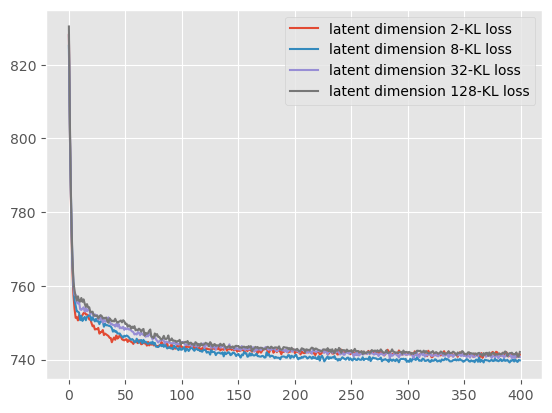

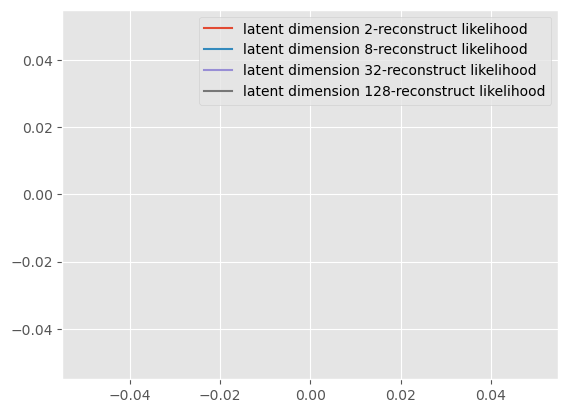

In [78]:
plt.figure()
for i,loss in enumerate(losses):
    plt.plot(loss, label=f'latent dimension {latent_size_list[i]}-KL loss')
plt.savefig('./loss.png')
plt.legend()
plt.figure()
print(len(losses_r))
for i,loss_r in enumerate(losses_r):   
    plt.plot(loss_r, label=f'latent dimension {latent_size_list[i]}-reconstruct likelihood')
    plt.legend()
plt.savefig('./loss_r.png')
